In [1]:
# importing the libraries

import os
import gc
import random
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score, make_scorer, matthews_corrcoef, f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold

import xgboost as xgb
import shap              # for model interpretability
import tensorflow as tf

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING

/home/arjun/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/arjun/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/arjun/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/arjun/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: Futu

In [2]:
# setting up the parameters

root_dir = os.path.dirname(os.path.abspath(os.getcwd()))
pd.set_option("display.max_rows", 16)
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

## Helper Functions

In [3]:
def train_test_split(dataframe, validation_ratio):
    """
    randomly splits the dataset into train and valid sets
    
    input: dataframe, validation ratio (the %age of data to feed into the )
    output: trainset and validset
    """
    num_train = len(dataframe)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(validation_ratio*num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    train_df, valid_df = dataframe.iloc[train_idx], dataframe.iloc[valid_idx]
    return train_df, valid_df

In [4]:
def weight_of_evidence(target_df, predictor_df, categorical_col, min_percentage):
    """
    calculates weight of evidence for the said column
    
    inp: target_df (dataframe of the variable to be predicted)
         predictor_df (dataframe of the independent variables)
         categorical_column (column to be WoE encoded)
         min_percentage you want to take into consideration. Classes less than this proportion won't be considered
    outp: transformed predicted_df[col], dict containing WoE.
    """
    # creating new dataframe with groupby-agg clause. We will calculate the positives (i.e. events) of every class
    woe_df = target_df.groupby(predictor_df[categorical_col]).agg(["sum", "count"]).rename({"sum": "positives"}, axis = 1)
    
    woe_df["negatives"] = woe_df["count"] - woe_df["positives"]                      # calculating negatives (i.e. non-events)
    woe_df[["positives", "negatives"]] /= woe_df[["positives", "negatives"]].sum()   # normalize
    min_fraction = min_percentage / 100                                              # converting to fraction
    
    # checking classes with proportion less than min_percentage, or ones who have positives or negatives equal to zero
    undefined = (woe_df["count"]/len(predictor_df) < min_fraction) | (woe_df["positives"] == 0) | (woe_df["negatives"] == 0)
    # replacing undefined with -1
    woe_df.loc[undefined, ["positives", "negatives"]] = -1
    
    # calculating weight of evidence
    woe_df["woe_value"] = np.log(woe_df["positives"] / woe_df["negatives"])
    woe_df["info_value"] = (woe_df["positives"] - woe_df["negatives"]) * woe_df["woe_value"]
    
    # calculate total information_value
    total_iv = sum(woe_df["info_value"])
    print("Information value of the {} is = {}".format(categorical_col, total_iv))
    
    # convert the woe_df into dictionary and map the changes to predictor column
    woe_dict = woe_df["woe_value"].to_dict()
    predictor_df[categorical_col] = predictor_df[categorical_col].map(woe_dict)
    
    return predictor_df, woe_dict


def woe_transform(test_df, categorical_column, encoder_dict):
    """
    transforms the testset with WoE calculated from test set
    
    inp: test_df, 
         categorical_column to be encoded,
         encoder_dict created from categorical column in trainset
    outp: test_df mapped with woe values
    """
    test_df[categorical_column] = test_df[categorical_column].map(encoder_dict)
    
    return test_df

In [5]:
def save_pickle(object_to_be_saved, path):
    """
    saves the object as pickle at the defined path
    
    inp: object to be saved,
         path
    returns: None
    """
    with open(path, "wb") as f:
        pickle.dump(object_to_be_saved, f)

def load_pickle(path):
    """
    saves the object as pickle at the defined path
    
    inp: path
    returns: pickle_object
    """
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    
    return obj

## 1. Preparing the data for Machine Learning Model
With the aggregation of data behind us, we still need to work on the data in order to feed the data to the Machine Learning model, so it can train on the data in the best way possible. One transformation that is required is the **Scaling** of the data, as most algorithms, like Deep Neural Nets, works considerably better when fed with scaled data. Other Machine Learning models like XGBoost are immune to scaling. So, scaling has no effect on XGBoost. 

Only continuous columns go through scaling. For categorical columns, we face other challenges. Foremost of these challenges is the high cardinality. For instance, the `app_code` column has 477 different values, which gives a very high cardinality to that particular column. To deal with this, we will use **Weight of Evidence**. In the weight of evidence algorithm, total number of records with the positive and negative class labels are also taken into account. For class imbalanced data, this algorithm works better. The advantages of using Weight of evidence are:-
- Handles missing values
- Handles outliers
- The transformation is based on logarithmic value of distributions. This is aligned with the logistic regression output function
- No need for dummy variables
- By using proper binning technique, it can establish monotonic relationship (either increase or decrease) between the independent and dependent variable

For the categorical variables, with fewer classes, we will use OneHotEncoder.

In [6]:
# importing the dataset
df = pd.read_csv(os.path.join(root_dir, "data", "processed_data", "train_aggdf.csv"))
df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,diff_time_mean,diff_time_max,diff_time_min,count_unique_app,hour,minute,vc_app_code,vc_user_id,app_code_count_unique_user,click_count_user_mean,time_elapsed_user,click_count_app_mean,time_elapsed_app,inst_count,user_unique_sessions,user_unique_item_ids,user_unique_category_1,user_unique_category_2,user_unique_category_3,user_unique_product_type,user_item_id_mode,user_category_1_mode,user_category_2_mode,user_category_3_mode,user_product_type_mode
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,2,0,0,74670.000000,148200.0,1140.0,1,0,0,395,3,51,-1.0,-1.0,-1.0,-1.0,1,1,1,1,1,1,1,43886,11.0,35.0,20.0,5622.0
1,c81e728d9d4c2f636f067f89cc14862c,2018-11-15 00:00:00,89464,129,0,0,0,101901.818182,347520.0,180.0,1,0,0,7050,23,2000,-1.0,-1.0,-1.0,-1.0,226,40,150,15,50,90,132,38517,17.0,9.0,62.0,8028.0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,2018-11-15 00:00:00,58442,127,1,0,0,68812.727273,165720.0,8400.0,1,0,0,10851,34,2039,-1.0,-1.0,-1.0,-1.0,32,15,12,8,10,10,12,73224,1.0,64.0,263.0,5164.0
3,a87ff679a2f3e71d9181a67b7542122c,2018-11-15 00:00:00,4238,371,1,0,0,540.000000,540.0,540.0,1,0,0,9343,2,1819,-1.0,-1.0,-1.0,-1.0,109,30,52,12,28,40,50,37336,17.0,8.0,84.0,231.0
4,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,1,1,1,45745.882353,167340.0,360.0,2,0,1,422,52,24,-1.0,-1.0,-1.0,-1.0,7,5,3,2,2,2,3,43209,4.0,74.0,292.0,577.0


In [7]:
# spliting the dataset
train_df, test_df = train_test_split(df, validation_ratio = 0.2)

print("shape of train_df = {}".format(train_df.shape))
print("shape of test_df = {}".format(test_df.shape))

# define predictors and targets in trainset and testset
x_train, y_train = train_df.drop(columns = ["impression_id", "user_id", "impression_time", "is_click", "minute"]), train_df["is_click"]
x_test, y_test = test_df.drop(columns = ["impression_id", "user_id", "impression_time", "is_click", "minute"]), test_df["is_click"]

print("-"*10)
print("Shape of x_train = {} ... y_train = {}".format(x_train.shape, y_train.shape))
print("Shape of x_test = {} ... y_test = {}".format(x_test.shape, y_test.shape))

shape of train_df = (190088, 32)
shape of test_df = (47521, 32)
----------
Shape of x_train = (190088, 27) ... y_train = (190088,)
Shape of x_test = (47521, 27) ... y_test = (47521,)


### 1.1. Encoding the Categorical variables

In [8]:
categorical_columns = ["app_code", "os_version", "is_4G", "count_unique_app"]
pd.DataFrame({"s": x_train[categorical_columns].nunique()})

,s
app_code,472
os_version,3
is_4G,2
count_unique_app,9


From the above table, it is pretty much clear that the predictor ``app_code`` and ``count_unique_app`` exhibits high cardinality. Because of this, we can't use techniques like one_hot_encoding, as it will give immense sparsity to the data and can't use LabelEncoding, as it will encode the values in ordinal manner, which might give unneccessary high weight to some classes. One of the techniques, we can use here is the Weigh of Evidence. 

In [9]:
#################################################
####### Calculating Weight of Evidence ##########
#################################################

x_train, app_code_dict = weight_of_evidence(y_train, x_train, categorical_col = "app_code", min_percentage = 0.01)
x_train, count_unique_app_dict = weight_of_evidence(y_train, x_train, categorical_col = "count_unique_app", min_percentage = 0.01)

save_pickle(app_code_dict, os.path.join(root_dir, "models", "app_code_dict.pkl"))
save_pickle(count_unique_app_dict, os.path.join(root_dir, "models", "count_unique_app_dict.pkl"))

Information value of the app_code is = 0.5978568936176862
Information value of the count_unique_app is = 0.007051186306573403


### 1.2. Scaling the variables

In [10]:
#####################################################
############## Scaling the data #####################
#####################################################

# define the scaler
scaler = MinMaxScaler()
train_scaler = scaler.fit(x_train)

# data columns
cols = x_train.columns

# save scaler object
save_pickle(train_scaler, os.path.join(root_dir, "models", "train_scaler.pkl"))

x_train_scaled = train_scaler.transform(x_train)

# scaled dataset would be of type ndarray. Converting it back to Pandas
x_train_scaled = pd.DataFrame(x_train_scaled)
x_train_scaled.columns = cols

x_train_scaled.head()

,app_code,os_version,is_4G,diff_time_mean,diff_time_max,diff_time_min,count_unique_app,hour,vc_app_code,vc_user_id,app_code_count_unique_user,click_count_user_mean,time_elapsed_user,click_count_app_mean,time_elapsed_app,inst_count,user_unique_sessions,user_unique_item_ids,user_unique_category_1,user_unique_category_2,user_unique_category_3,user_unique_product_type,user_item_id_mode,user_category_1_mode,user_category_2_mode,user_category_3_mode,user_product_type_mode
0,0.094906,0.5,1.0,0.000000,0.000000,0.000000,0.971219,0.434783,0.908781,0.000000,1.000000,0.0,0.000000,0.503979,0.000027,0.041930,0.100000,0.088346,0.800000,0.447761,0.219512,0.108696,0.542859,0.833333,0.5500,0.654971,0.622625
1,0.516585,1.0,0.0,0.052224,0.177665,0.000152,0.971219,0.913043,0.516175,0.125000,0.195613,0.5,0.177908,0.520804,0.000080,0.012062,0.050000,0.030075,0.666667,0.194030,0.085366,0.038647,0.542859,0.277778,0.4875,0.184211,0.987619
2,0.564348,0.0,0.0,0.055105,0.365190,0.000607,0.971219,0.652174,0.321129,0.222222,0.114327,0.5,0.048104,0.524629,0.000027,0.000574,0.003571,0.001880,0.066667,0.014925,0.006098,0.002415,0.577310,0.611111,0.8000,0.634503,0.001229
3,0.734442,1.0,0.0,0.118357,0.289416,0.000025,0.971219,0.000000,0.083346,0.055556,0.078256,0.5,0.289812,0.550489,0.000027,0.087881,0.160714,0.216165,0.933333,0.597015,0.451220,0.243961,0.739376,0.555556,0.0500,0.184211,0.465457
4,0.538512,0.0,0.0,0.103917,0.291287,0.000051,0.971219,0.391304,0.001539,0.097222,0.001010,0.5,0.000051,0.500000,0.000053,0.033314,0.050000,0.090226,0.933333,0.477612,0.243902,0.111111,0.021377,1.000000,0.1125,0.622807,0.962574


In [11]:
x_train.head()

,app_code,os_version,is_4G,diff_time_mean,diff_time_max,diff_time_min,count_unique_app,hour,vc_app_code,vc_user_id,app_code_count_unique_user,click_count_user_mean,time_elapsed_user,click_count_app_mean,time_elapsed_app,inst_count,user_unique_sessions,user_unique_item_ids,user_unique_category_1,user_unique_category_2,user_unique_category_3,user_unique_product_type,user_item_id_mode,user_category_1_mode,user_category_2_mode,user_category_3_mode,user_product_type_mode
11556,-1.786352,1,1,0.000000,0.0,0.0,0.010469,10,30706,1,17827,-1.0,-1.0,0.007958,60.0,73,28,47,12,30,36,45,72120,14.0,43.0,223.0,6587.0
72885,-0.052883,2,0,123933.333333,421620.0,360.0,0.010469,21,17441,10,3488,0.0,421620.0,0.041608,180.0,21,14,16,10,13,14,16,72120,4.0,38.0,62.0,10449.0
126536,0.143465,0,0,130770.000000,866640.0,1440.0,0.010469,15,10851,17,2039,0.0,114000.0,0.049259,60.0,1,1,1,1,1,1,1,76697,10.0,63.0,216.0,12.0
169596,0.842700,2,0,280875.000000,686820.0,60.0,0.010469,0,2817,5,1396,0.0,686820.0,0.100977,60.0,153,45,115,14,40,74,101,98228,9.0,3.0,62.0,4924.0
69055,0.037255,0,0,246608.571429,691260.0,120.0,0.010469,9,53,8,19,0.0,120.0,0.000000,120.0,58,14,48,14,32,40,46,2839,17.0,8.0,212.0,10184.0


---
## 2. Machine Learning Models
### 2.1. XGBoost

In [13]:
def f1_eval(y_pred, y_true):
    """
    custom eval metric for XGBClassifier
    """
    err = 1 - f1_score(y_true, np.round(y_pred))
    return "f1_err", err

In [14]:
def hyperparameter_tuning(params):
    """
    hypertunes a XGBoost model
    
    inp: parameters
    outp: score per fold
    """
    params = {
        "max_depth": int(params["max_depth"]),                              # max depth of the tree
        "gamma": "{:.3f}".format(params["gamma"]),                          # min loss reduction required to make a split
        "subsample": "{:.2f}".format(params["subsample"]),                  # denotes the fraction of observations to be randomly samples for each tree
        "reg_alpha": "{:.3f}".format(params["reg_alpha"]),                  # L1 regularization weight
        "reg_lambda": "{:.3f}".format(params["reg_lambda"]),                # L2 regularization weight
        "learning_rate": "{:.3f}".format(params["learning_rate"]),          # learning rate of XGB
        "num_leaves": "{:.3f}".format(params["num_leaves"]),                 
        "colsample_bytree": "{:.3f}".format(params["colsample_bytree"]),
        "min_child_samples": "{:.3f}".format(params["min_child_samples"]),
        "feature_fraction": "{:.3f}".format(params["feature_fraction"]),
        "bagging_fraction": "{:.3f}".format(params["bagging_fraction"]),
        "objective": "binary:logistic",
        "scale_pos_weight": 20,                                             # sum(negative instances) / sum(positive instances)
        #"f_eval": f1_eval,
        "eval_metric": "error"
    }
    
    print("#"*25)
    print("Params = {}".format(params))
    FOLDS = 10  # defining the folds required
    count = 1   # count of HPT cycles
    skf = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state = 42)
    y_oof = np.zeros(x_train.shape[0])
    ROC_mean = 0
    for trn_idx, val_idx in skf.split(x_train, y_train):
        # define the classifier
        clf = xgb.XGBClassifier(random_state = 42, 
                                verbose = True, 
                                tree_method = "gpu_hist",
                                **params)
        # spliting data into train and valid sets
        train_x, valid_x = x_train.iloc[trn_idx], x_train.iloc[val_idx]
        train_y, valid_y = y_train.iloc[trn_idx], y_train.iloc[val_idx]
        
        # fit the estimator and predict
        clf.fit(train_x, train_y)
        pred = clf.predict(valid_x)
        # eval metrics
        score_ROC = make_scorer(roc_auc_score, needs_proba = True)(clf, valid_x, valid_y)
        score_F1 = f1_score(valid_y.values, pred, average = "binary")
        score_MCC = matthews_corrcoef(valid_y.values, pred)
        ROC_mean += score_ROC
        print("Count = {} ... score_ROC = {:.4f} ... score_F1 = {:.4f} ... score_MCC = {:.4f}".format(count, score_ROC, score_F1, score_MCC))
        count += 1
    
    gc.collect()
    print("Mean ROC_AUC = {:.4}".format(ROC_mean / FOLDS))
    del train_x, valid_x, train_y, valid_y, clf, score_ROC
    
    return -(ROC_mean/FOLDS)

In [15]:
space = {
    "max_depth": hp.quniform("max_depth", 6, 8, 1),
    "reg_alpha": hp.uniform("reg_alpha", 0.01, 0.05),
    "reg_lambda": hp.uniform("reg_lambda", 0.01, 0.05),
    "learning_rate": hp.uniform("learning_rate", 0.001, 0.2),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.3, 0.9),
    "gamma": hp.uniform("gamma", 0.01, 0.7),
    "num_leaves": hp.choice("num_leaves", list(range(20, 250, 10))),
    "min_child_samples": hp.choice("min_child_samples", list(range(100, 250, 10))),
    "subsample": hp.choice('subsample', [0.2, 0.4, 0.5, 0.6, 0.7, .8, .9]),
    'feature_fraction': hp.uniform('feature_fraction', 0.4, .8),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.4, .9)
}

In [16]:
%%time

# Set algoritm parameters
best = fmin(fn = hyperparameter_tuning,
            space = space,
            algo = tpe.suggest,
            max_evals = 50)

# Print best parameters
best_params = space_eval(space, best)

#########################                           
Params = {'max_depth': 7, 'gamma': '0.512', 'subsample': '0.80', 'reg_alpha': '0.049', 'reg_lambda': '0.038', 'learning_rate': '0.016', 'num_leaves': '140.000', 'colsample_bytree': '0.741', 'min_child_samples': '200.000', 'feature_fraction': '0.605', 'bagging_fraction': '0.776', 'objective': 'binary:logistic', 'scale_pos_weight': 20, 'eval_metric': 'error'}
Count = 1 ... score_ROC = 0.7365 ... score_F1 = 0.1573 ... score_MCC = 0.1549
Count = 2 ... score_ROC = 0.7446 ... score_F1 = 0.1590 ... score_MCC = 0.1591
Count = 3 ... score_ROC = 0.7372 ... score_F1 = 0.1560 ... score_MCC = 0.1531
Count = 4 ... score_ROC = 0.7288 ... score_F1 = 0.1512 ... score_MCC = 0.1428
Count = 5 ... score_ROC = 0.7433 ... score_F1 = 0.1578 ... score_MCC = 0.1554
Count = 6 ... score_ROC = 0.7360 ... score_F1 = 0.1575 ... score_MCC = 0.1542
Count = 7 ... score_ROC = 0.7361 ... score_F1 = 0.1555 ... score_MCC = 0.1512
Count = 8 ... score_ROC = 0.7303 ... scor

In [12]:
# final chosen parameter
params = {
    'max_depth': 6, 
    'gamma': '0.452', 
    'subsample': '0.80', 
    'reg_alpha': '0.011', 
    'reg_lambda': '0.019', 
    'learning_rate': '0.015', 
    'num_leaves': '50.000', 
    'colsample_bytree': '0.748', 
    'min_child_samples': '170.000', 
    'feature_fraction': '0.538', 
    'bagging_fraction': '0.756', 
    'objective': 'binary:logistic', 
    'scale_pos_weight': 20, 
    'eval_metric': 'error'
}


# define the classifier
xgb_clf = xgb.XGBClassifier(random_state = 42, 
                            verbose = True, 
                            #tree_method = "gpu_hist",
                            **params)

# fit the classifier
xgb_clf.fit(x_train, y_train)

# encoding the x_test
x_test = woe_transform(x_test, categorical_column = "app_code", encoder_dict = app_code_dict)
x_test = woe_transform(x_test, categorical_column = "count_unique_app", encoder_dict = count_unique_app_dict)

# predict with the trained classifier
preds = xgb_clf.predict(x_test)

# printing the confusion matrix
con_mat = confusion_matrix(y_test.values, preds)
print(con_mat)

[[28180 17215]
 [  610  1516]]


In [13]:
# Model Performance
print("Accuracy = {:.2f}%".format(accuracy_score(y_test.values, preds)*100))
print("Precision = {:.3f}".format(precision_score(y_test.values, preds)))
print("Recall = {:.3f}".format(recall_score(y_test.values, preds)))
print("F1 Score = {:.3f}".format(f1_score(y_test.values, preds)))

Accuracy = 62.49%
Precision = 0.081
Recall = 0.713
F1 Score = 0.145


In [41]:
# saving the xgb model
pickle.dump(xgb_clf, open(os.path.join(root_dir, "models", "xgb_clf.pkl"), "wb"))

#xgb_model_loaded = pickle.load(open(os.path.join(root_dir, "models", "xgb_clf.pkl"), "rb"))

# preds = xgb_model_loaded.predict(x_test)

# # printing the confusion matrix
# con_mat = confusion_matrix(y_test.values, preds)
# print(con_mat)

[[28600 16754]
 [  589  1578]]


---
Looking at the above *confusion matrix*, two conclusions can be drawn:-
- the number of false positives is insanely high.
- the hyperparameter tuning may not give us the good performance. So, we need to explore new other techniques.

As, we already have tried the **StratifiedKFold**, we need to now explore other sampling algorithms, that can allow our model to learn better. One solution to this problem could be using *Majority Under-Sampling, Minority Over-Sampling*. The way we can implement this is by **SMOTE**, which stands for Synthetic Minority Over-sampling Technique. The following code snippet will implement SMOTE from scratch (to understand the algorithm better, though a library called imblearn is also available). 

This algorithm is attributed to [this post](https://medium.com/@breya.heysoftware/synthetic-minority-over-sampling-technique-smote-from-scratch-e1167f788434):-
- Identify the feature vector and its nearest neighbour
- Take the difference between the two
- Multiply the difference with a random number between 0 and 1
- Identify a new point on the line segment by adding the random number to feature vector
- Repeat the process for identified feature vector

**NOTE** - for the best performance of the SMOTE, the data should be normalized. As I used XGBoost algorithm, I didn't scaled the data. That's because, tree based algorithm are immune to scale of the dataset.

In [14]:
def n_neighbors(x_trainset):
    """
    inp: trainset without labels
    outp: indices for nearest neighbors
    """
    neighbors = NearestNeighbors(n_neighbors = 5, metric = "euclidean", algorithm = "kd_tree").fit(x_trainset)
    euclidean, indices = neighbors.kneighbors(x_trainset)
    return indices

In [15]:
def smote(minclass_arr):
    """
    implements SMOTE (Synthetic Minority Over-sampling Technique)
    
    inp: trainset without labels,
         minority class array
    outp: matrix
    """
    # get indices from n_neighbors function defined earlier
    indices = n_neighbors(minclass_arr)
    matrix = []
    for m in range(0, len(indices)):
        temp = minclass_arr[indices[m]]
        temp = pd.DataFrame(temp)
        matrix.append([])
        for j in range(0, len(temp.columns)):
            matrix[m].append(random.choice(temp[j]))
    return matrix

In [16]:
# getting minority classes instances in the trainset
unique, counts = np.unique(y_train, return_counts = True)

# Create a minority_shape variable which contains the dimension of the minority class
minority_shape = dict(zip(unique, counts))[1]

# storing minority class instances seperately
minclass_arr = np.ones((minority_shape, x_train_scaled.shape[1]))
minclass_arr = [x_train.iloc[i] for i, v in enumerate(y_train) if v == 1.0]
minclass_arr = np.array(minclass_arr)

# apply SMOTE
sampled_instances = smote(minclass_arr)

# Keeping the artificial instances and original instances together
x_train_oversampled = np.concatenate((x_train_scaled, sampled_instances), axis = 0)
y_sampled_instances = np.ones(minority_shape)
y_train_oversampled = np.concatenate((y_train, y_sampled_instances), axis=0)

x_train_oversampled = pd.DataFrame(x_train_oversampled)
y_train_oversampled = pd.DataFrame(y_train_oversampled)
x_train_oversampled.columns = cols 

print("Shape of x_train_oversampled = {} ... y_train_oversampled = {}".format(x_train_oversampled.shape, y_train_oversampled.shape))
print("Class ratio = {}".format(len(y_train_oversampled[y_train_oversampled == 0].dropna())/len(y_train_oversampled[y_train_oversampled == 1].dropna())))

Shape of x_train_oversampled = (198723, 27) ... y_train_oversampled = (198723, 1)
Class ratio = 10.506832657788072


In [17]:
# final chosen parameter
params = {
    'max_depth': 6, 
    'gamma': '0.452', 
    'subsample': '0.80', 
    'reg_alpha': '0.011', 
    'reg_lambda': '0.019', 
    'learning_rate': '0.015', 
    'num_leaves': '50.000', 
    'colsample_bytree': '0.748', 
    'min_child_samples': '170.000', 
    'feature_fraction': '0.538', 
    'bagging_fraction': '0.756', 
    'objective': 'binary:logistic', 
    'scale_pos_weight': 10, 
    'eval_metric': 'error'
}

# define the classifier
xgb_clf = xgb.XGBClassifier(random_state = 42, 
                            verbose = True, 
                            tree_method = "gpu_hist",
                            **params)

# fit the classifier
xgb_clf.fit(x_train_oversampled, y_train_oversampled)

# predict with the trained classifier
x_test_scaled = train_scaler.transform(x_test)
x_test_scaled = pd.DataFrame(x_test_scaled)
x_test_scaled.columns = cols
preds = xgb_clf.predict(x_test_scaled)

# printing the confusion matrix
con_mat = confusion_matrix(y_test.values, preds)
print(con_mat)

[[41430  3864]
 [ 1622   605]]


In [18]:
# Model Performance after SMOTE
print("Accuracy = {:.2f}%".format(accuracy_score(y_test.values, preds)*100))
print("Precision = {:.3f}".format(precision_score(y_test.values, preds)))
print("Recall = {:.3f}".format(recall_score(y_test.values, preds)))
print("F1 Score = {:.3f}".format(f1_score(y_test.values, preds)))

Accuracy = 88.46%
Precision = 0.135
Recall = 0.272
F1 Score = 0.181


---
## 3. Understanding the model performance

In [16]:
shap_values = shap.TreeExplainer(xgb_clf).shap_values(x_train)

#### SHAP Summary Plot
The SHAP values for XGBoost explain the margin output of the model, which is the change in log odds of dying for a Cox proportional hazards model.

This summary plot replaces the typical bar chart of feature importance. It tells which features are most important, and also their range of effects over the dataset. The color allows us match how changes in the value of a feature effect the change.

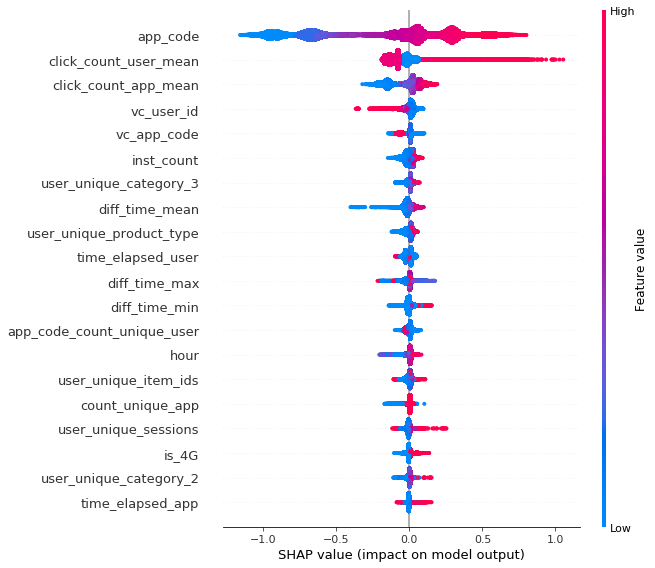

In [17]:
shap.summary_plot(shap_values, x_train)

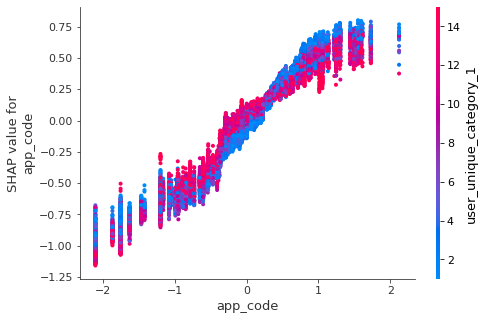

In [19]:
shap.dependence_plot("app_code", shap_values, x_train)

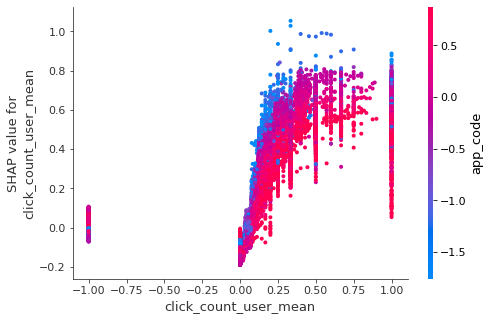

In [21]:
shap.dependence_plot("click_count_user_mean", shap_values, x_train)

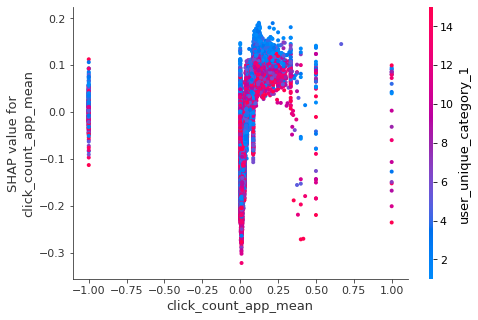

In [22]:
shap.dependence_plot("click_count_app_mean", shap_values, x_train)

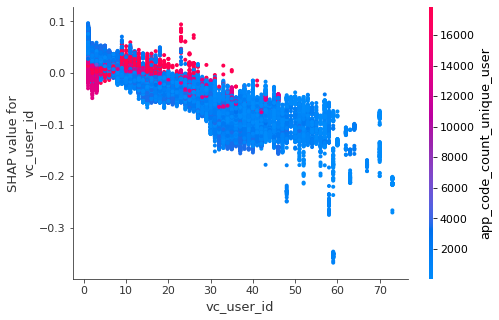

In [23]:
shap.dependence_plot("vc_user_id", shap_values, x_train)

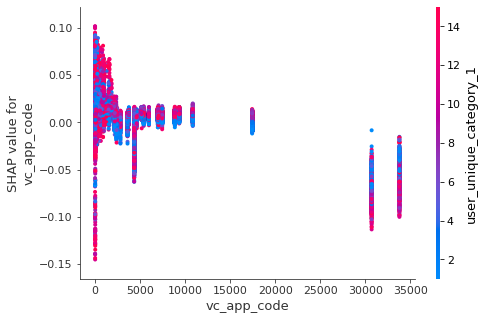

In [24]:
shap.dependence_plot("vc_app_code", shap_values, x_train)

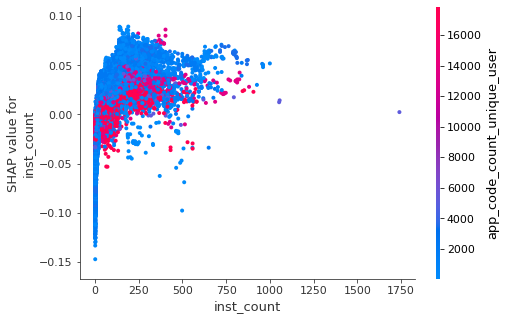

In [25]:
shap.dependence_plot("inst_count", shap_values, x_train)

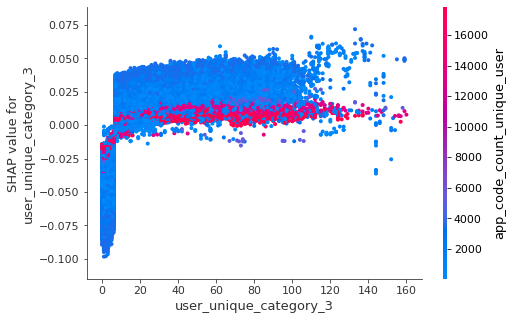

In [27]:
shap.dependence_plot("user_unique_category_3", shap_values, x_train)

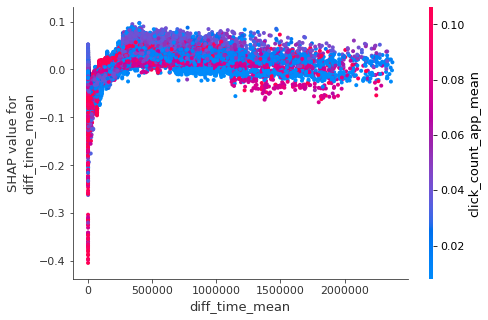

In [28]:
shap.dependence_plot("diff_time_mean", shap_values, x_train)

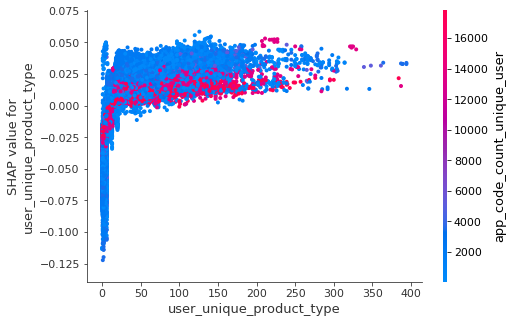

In [29]:
shap.dependence_plot("user_unique_product_type", shap_values, x_train)

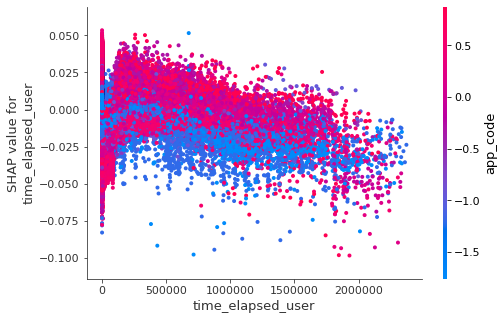

In [30]:
shap.dependence_plot("time_elapsed_user", shap_values, x_train)

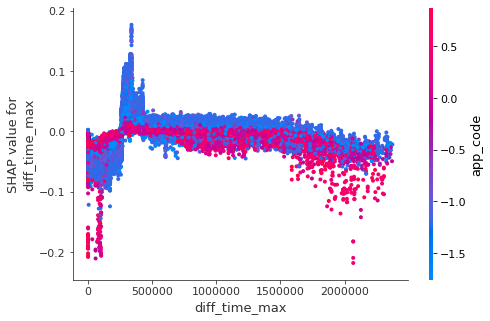

In [31]:
shap.dependence_plot("diff_time_max", shap_values, x_train)

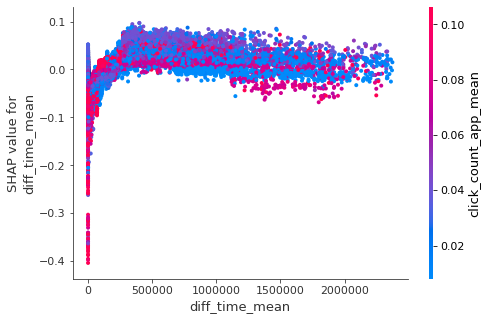

In [32]:
shap.dependence_plot("diff_time_mean", shap_values, x_train)

In [14]:
shap_interaction_values = shap.TreeExplainer(xgb_clf).shap_interaction_values(x_train[:2000])

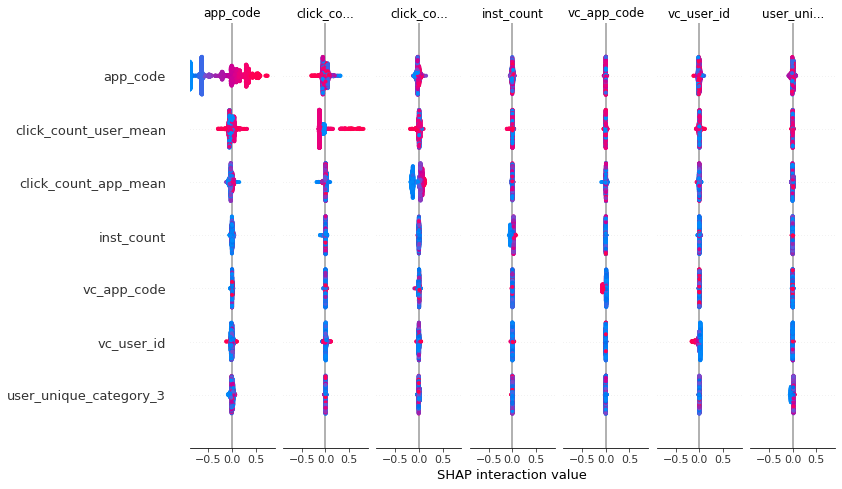

In [16]:
shap.summary_plot(shap_interaction_values, x_train[:2000])

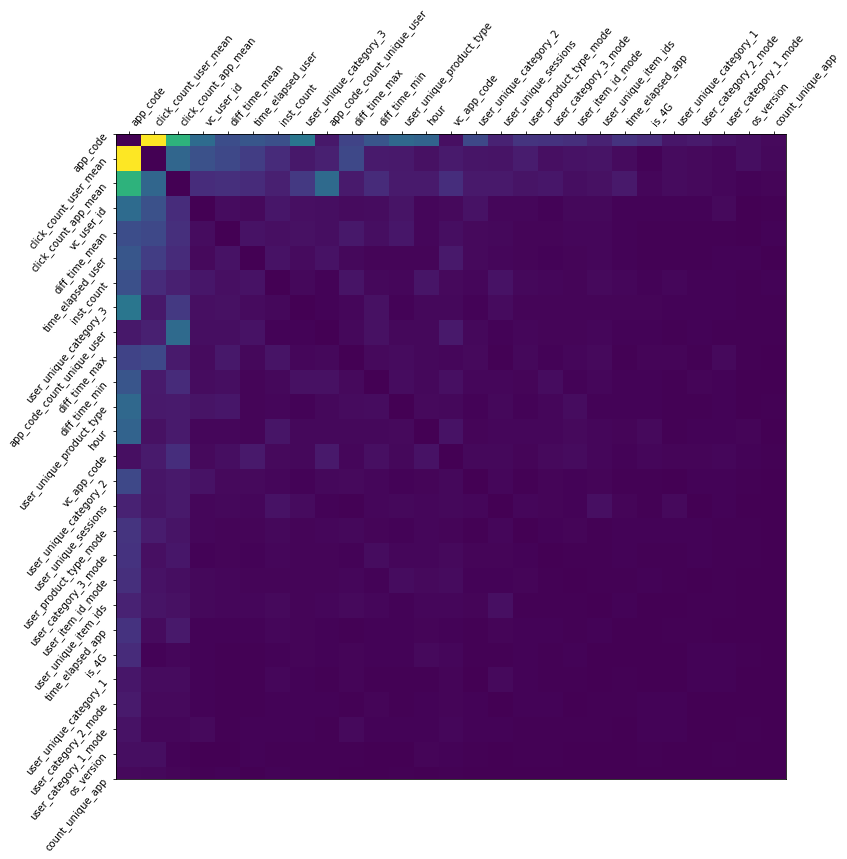

In [19]:
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
plt.figure(figsize=(12,12))
plt.imshow(tmp2)
plt.yticks(range(tmp2.shape[0]), x_train[:2000].columns[inds], rotation = 50.4, horizontalalignment = "right")
plt.xticks(range(tmp2.shape[0]), x_train[:2000].columns[inds], rotation = 50.4, horizontalalignment = "left")
plt.gca().xaxis.tick_top()
plt.show()